Fitting ['kate_ph_repeat'] with 10 data points


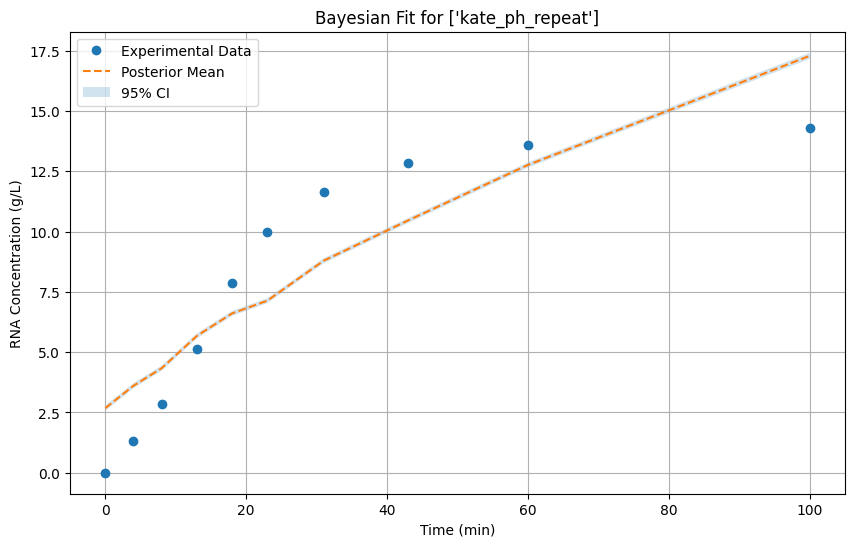

Fitting ['charlie_ph', 'Sheet1'] with 9 data points


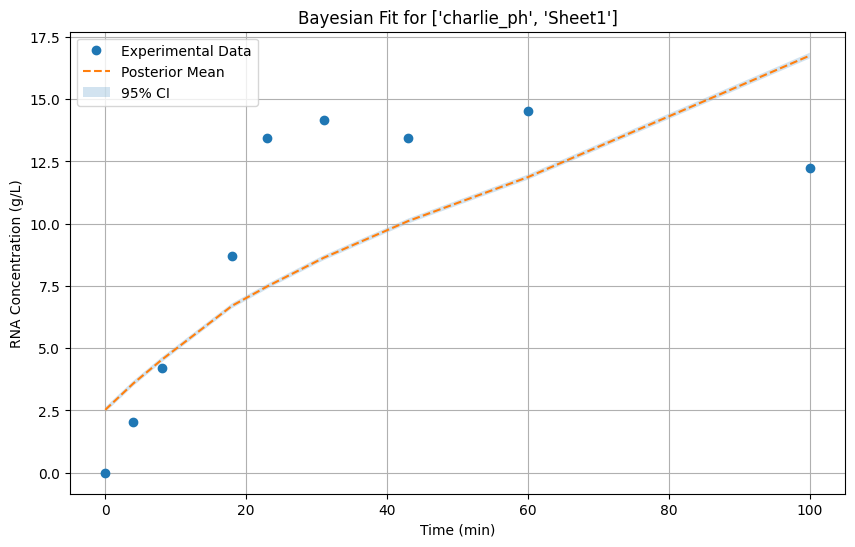

Fitting ['ricardo_ph', 'CSP HEPES'] with 7 data points


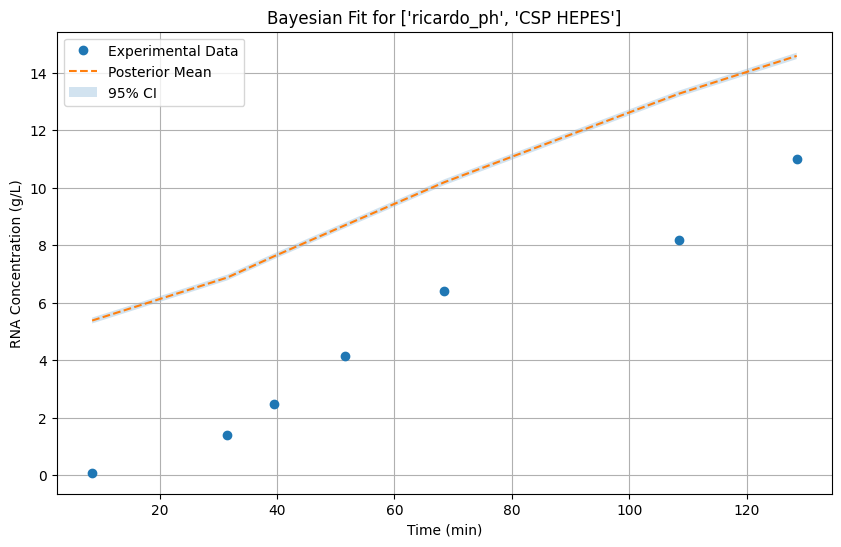

Fitting ['ricardo_ph', 'eGFP HEPES'] with 11 data points


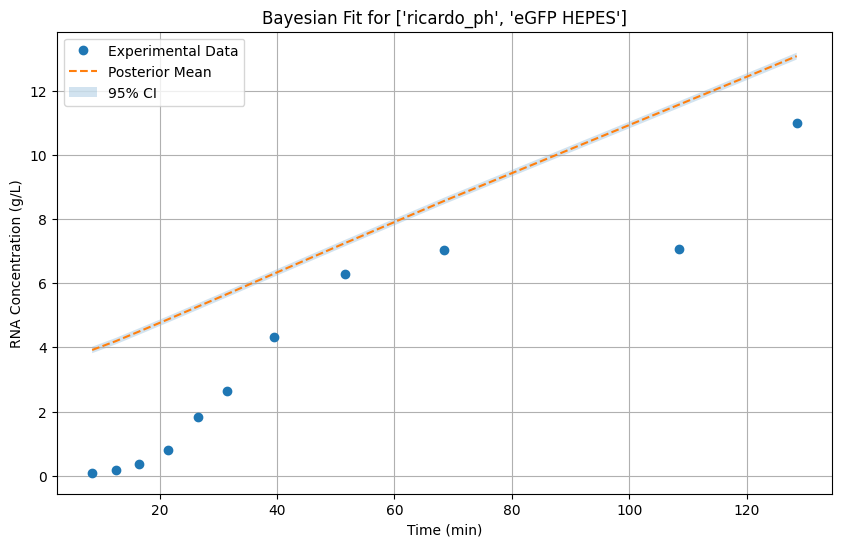

Fitting ['ricardo_ph', 'eGFP TRIS'] with 11 data points


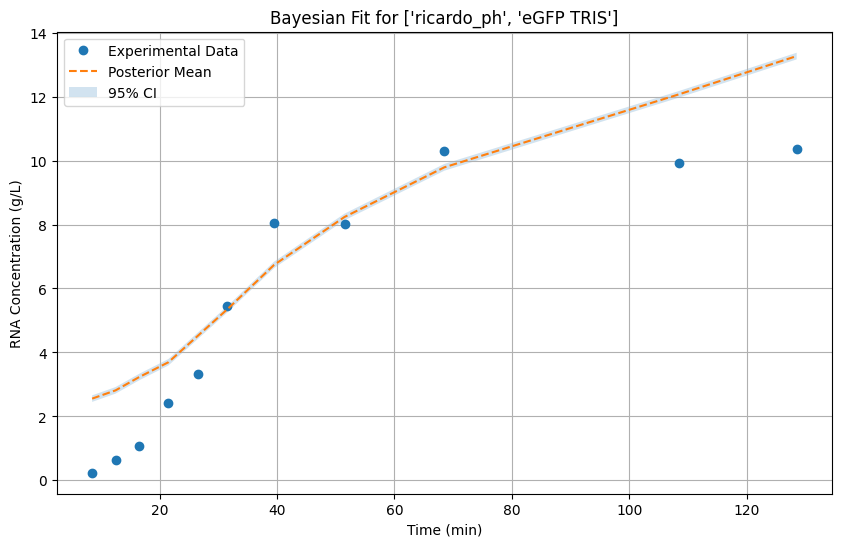

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import r3.schema as schema
import r3.adapters as adapters


# === Bayesian Linear Regression Utilities ===
def bayesian_linear_update(mu_prior, Sigma_prior, X, y, sigma2):
    precision_prior = np.linalg.inv(Sigma_prior)
    precision_likelihood = X.T @ X / sigma2
    Sigma_post = np.linalg.inv(precision_prior + precision_likelihood)
    mu_post = Sigma_post @ (precision_prior @ mu_prior + (X.T @ y) / sigma2)
    return mu_post, Sigma_post


def predict(X, mu, Sigma, sigma2):
    mean = X @ mu
    var = np.sum(X @ Sigma * X, axis=1) + sigma2
    return mean, var


# === Config ===
sigma2 = 0.05**2  # estimated noise variance
d = 3  # bias + pH + time
mu_prior = np.zeros(d)
Sigma_prior = np.eye(d) * 1.0

X_columns = [
    schema.IVTReactionSchema.pH.value,
    schema.IVTReactionSchema.TIME_min.value,
]
y_columns = [schema.IVTReactionSchema.RNA_g_L.value]

experimental_conditions, response = adapters.DataPipelineAdapter(
    "kate_ph_repeat", verbose=False
).get_all(
    X_columns=X_columns,
    y_columns=y_columns,
    paths=[
        ["charlie_ph", "Sheet1"],
        ["ricardo_ph", "CSP HEPES"],
        ["ricardo_ph", "eGFP HEPES"],
        ["ricardo_ph", "eGFP TRIS"],
    ],
)

# === Bayesian Linear Regression Loop ===
for index, (source, X_df) in enumerate(experimental_conditions):
    y_df = response[index][1]

    # Design matrix with bias
    X = np.c_[np.ones(len(X_df)), X_df.values]  # shape: (n, 3)
    y = y_df.values.flatten()  # shape: (n,)

    print(f"Fitting {source} with {len(y)} data points")

    # Update posterior
    mu_post, Sigma_post = bayesian_linear_update(mu_prior, Sigma_prior, X, y, sigma2)

    # Predictive mean + uncertainty
    mean_pred, var_pred = predict(X, mu_post, Sigma_post, sigma2)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(X[:, 2], y, "o", label="Experimental Data")
    plt.plot(X[:, 2], mean_pred, "--", label="Posterior Mean")
    plt.fill_between(
        X[:, 2],
        mean_pred - 1.96 * np.sqrt(var_pred),
        mean_pred + 1.96 * np.sqrt(var_pred),
        alpha=0.2,
        label="95% CI",
    )
    plt.title(f"Bayesian Fit for {source}")
    plt.xlabel("Time (min)")
    plt.ylabel("RNA Concentration (g/L)")
    plt.legend()
    plt.grid()
    plt.show()

    # Pass posterior as prior to next dataset
    mu_prior = mu_post
    Sigma_prior = Sigma_post